In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import keras.backend as K
import os
import random
import matplotlib.pyplot as plt
tfk = tf.keras
tfkl = tf.keras.layers
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from vit_keras import vit, utils

# Random seed for reproducibility
seed = 21
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Versione di TensorFlow:", tf.__version__)

2023-12-01 11:14:46.247224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 11:14:46.247298: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 11:14:46.247338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 11:14:46.257025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


/home/simones95/.venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-12-01 11:14:49.170059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 11:14:49.177500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from 

Num GPUs Available:  1
Versione di TensorFlow: 2.14.0


In [2]:
#Parameters

path_images = "/dataset/new_simones/AerialWaste2"
path_json = "/home/simones95/EnvCrime"
AW1 = False
AW2 = not AW1

oversampling = True
OHE = False

batch_size = 2 #8
spatial_resolution = 30
max_dim = 736 #736 #1088
max_shape = tf.constant((max_dim, max_dim))

learning_rate = 1.0e-5
l2 = 1.0e-1

2023-12-01 11:14:49.192182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 11:14:49.194080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 11:14:49.195947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def load_data(name_json):
    # Load dataset for binary classification
    dataset = json.load(open(os.path.join(path_json, name_json)))
    if 'training' in name_json:
        pairs = [[os.path.join(path_images, 'images', d['file_name']), d['is_candidate_location']] for d in dataset['images']]
    else:
        if AW1: 
            pairs = [[os.path.join(path_images, 'images', d['file_name']), d['is_candidate_location']] for d in dataset['images']]
        else:
            pairs = [[os.path.join(path_images, 'images', d['file_name']), d['is_suspicius_location']] for d in dataset['images']]
            
    #Shuffle the pairs
    random.shuffle(pairs)
    
    # Extract info_images and their binary labels
    info_images, binary_labels = zip(*pairs)
    info_images = list(info_images)
    binary_labels = list(binary_labels)
    
    return info_images, binary_labels

if AW1:
    training_json = "training_aw1.json"
    testing_json = "testing_aw1.json"
elif AW2:
    training_json = "training_aw2.json"
    testing_json = "testing_aw2.json"

training_info_images, training_binary_labels = load_data(training_json)
num_samples_training = int(len(training_info_images) * 0.8)
validation_info_images, validation_binary_labels = training_info_images[num_samples_training:], training_binary_labels[num_samples_training:]
training_info_images, training_binary_labels = training_info_images[:num_samples_training], training_binary_labels[:num_samples_training]
testing_info_images, testing_binary_labels = load_data(testing_json)

print("Training: ", len(training_info_images), " ", len(training_info_images)/10434)
print("Validation: ", len(validation_info_images), " ", len(validation_info_images)/10434)
print("Testing: ", len(testing_info_images), " ", len(testing_info_images)/10434)

print("Training - Positive: ", sum(training_binary_labels), " - Negative: ", len(training_binary_labels) - sum(training_binary_labels))
print("Validation - Positive: ", sum(validation_binary_labels), " - Negative: ", len(validation_binary_labels) - sum(validation_binary_labels))
print("Testing - Positive: ", sum(testing_binary_labels), " - Negative: ", len(testing_binary_labels) - sum(testing_binary_labels))

Training:  6697   0.6418439716312057
Validation:  1675   0.16053287329883076
Testing:  2605   0.24966455817519648
Training - Positive:  2237  - Negative:  4460
Validation - Positive:  556  - Negative:  1119
Testing - Positive:  866  - Negative:  1739


In [4]:
def RandomOversampling(info_images, binary_labels):
    upsampling_factor = len(binary_labels)-2*sum(binary_labels)
    positive_indices = [i for i, value in enumerate(binary_labels) if value == 1]
    random.shuffle(positive_indices)
    for i in range(upsampling_factor):
        if i < len(positive_indices):
            info_images.append(info_images[positive_indices[i]])
            binary_labels.append(binary_labels[positive_indices[i]])
        
    upsampling_factor = len(binary_labels)-2*sum(binary_labels)
    if upsampling_factor > 0:
        info_images, binary_labels = RandomOversampling(info_images, binary_labels)
        
    random.seed(seed)
    random.shuffle(info_images)
    random.seed(seed)
    random.shuffle(binary_labels)
    
    return info_images, binary_labels

if oversampling:
    training_info_images, training_binary_labels = RandomOversampling(training_info_images, training_binary_labels)

print("Training - Positive: ", sum(training_binary_labels), " - Negative: ", len(training_binary_labels) - sum(training_binary_labels))

Training - Positive:  4460  - Negative:  4460


In [5]:
# One-hot encoding
if OHE:
    num_classes = 2
    
    def one_hot_encoding(label, num_classes):
        one_hot_vector = [0.0] * num_classes
        one_hot_vector[label] = 1.0
        return one_hot_vector

    training_binary_labels = [one_hot_encoding(label, num_classes) for label in training_binary_labels]
    validation_binary_labels = [one_hot_encoding(label, num_classes) for label in validation_binary_labels]
    testing_binary_labels = [one_hot_encoding(label, num_classes) for label in testing_binary_labels]

In [6]:
# Custom Generator
def load(info_image, label):
    image = tf.io.read_file(info_image)
    image = tf.image.decode_png(image, channels=3)
    
    shape = tf.shape(image)
    spatial_resolution_image = 210 * 100 / tf.maximum(shape[0],shape[1])
    
    #spatial_resolution_image = tf.random.uniform(shape=[], minval=20, maxval=30, dtype=tf.float64)
    new_shape_image = tf.cast(tf.cast(shape, tf.float64) * (spatial_resolution_image / spatial_resolution), tf.int32)
    
    image = tf.image.resize(image, size=new_shape_image[0:2])
    
    offset = max_shape - new_shape_image[0:2]
    if offset[0] % 2 == 0 and offset[1] % 2 == 0:
        image_channel0 = tf.pad(image[:,:,0], [[offset[0]//2, offset[0]//2], [offset[1]//2, offset[1]//2]], mode="CONSTANT", constant_values=80.9056)
        image_channel1 = tf.pad(image[:,:,1], [[offset[0]//2, offset[0]//2], [offset[1]//2, offset[1]//2]], mode="CONSTANT", constant_values=84.9275)
        image_channel2 = tf.pad(image[:,:,2], [[offset[0]//2, offset[0]//2], [offset[1]//2, offset[1]//2]], mode="CONSTANT", constant_values=70.8963)
    elif offset[0] % 2 == 0 and offset[1] % 2 != 0:
        image_channel0 = tf.pad(image[:,:,0], [[offset[0]//2, offset[0]//2], [offset[1]//2, offset[1]//2+1]], mode="CONSTANT", constant_values=80.9056)
        image_channel1 = tf.pad(image[:,:,1], [[offset[0]//2, offset[0]//2], [offset[1]//2, offset[1]//2+1]], mode="CONSTANT", constant_values=84.9275)
        image_channel2 = tf.pad(image[:,:,2], [[offset[0]//2, offset[0]//2], [offset[1]//2, offset[1]//2+1]], mode="CONSTANT", constant_values=70.8963)
    elif offset[0] % 2 != 0 and offset[1] % 2 == 0:
        image_channel0 = tf.pad(image[:,:,0], [[offset[0]//2, offset[0]//2+1], [offset[1]//2, offset[1]//2]], mode="CONSTANT", constant_values=80.9056)
        image_channel1 = tf.pad(image[:,:,1], [[offset[0]//2, offset[0]//2+1], [offset[1]//2, offset[1]//2]], mode="CONSTANT", constant_values=84.9275)
        image_channel2 = tf.pad(image[:,:,2], [[offset[0]//2, offset[0]//2+1], [offset[1]//2, offset[1]//2]], mode="CONSTANT", constant_values=70.8963)
    else:
        image_channel0 = tf.pad(image[:,:,0], [[offset[0]//2, offset[0]//2+1], [offset[1]//2, offset[1]//2+1]], mode="CONSTANT", constant_values=80.9056)
        image_channel1 = tf.pad(image[:,:,1], [[offset[0]//2, offset[0]//2+1], [offset[1]//2, offset[1]//2+1]], mode="CONSTANT", constant_values=84.9275)
        image_channel2 = tf.pad(image[:,:,2], [[offset[0]//2, offset[0]//2+1], [offset[1]//2, offset[1]//2+1]], mode="CONSTANT", constant_values=70.8963)
    
    image_channel0 = tf.expand_dims(image_channel0, axis=-1)
    image_channel1 = tf.expand_dims(image_channel1, axis=-1)
    image_channel2 = tf.expand_dims(image_channel2, axis=-1)
    image = tf.concat([image_channel0, image_channel1, image_channel2], axis=-1)
    
    return image, label

def make_dataset(info_images, binary_labels):
    return tf.data.Dataset.from_tensor_slices((info_images, binary_labels))\
        .map(load)\
        .batch(batch_size)\
        .prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(training_info_images, training_binary_labels)
val_ds = make_dataset(validation_info_images, validation_binary_labels)
test_ds = make_dataset(testing_info_images, testing_binary_labels)

(2, 736, 736, 3)
tf.Tensor(1, shape=(), dtype=int32)


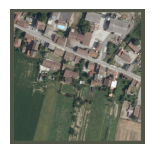

In [7]:
for i,o in train_ds.take(1):
  print(i.shape)
  plt.figure(figsize=(8, 8))
  for index in range(1):
    print(o[index])
    plt.subplot(2, 4, index+1)
    plt.imshow(i[index]/255, cmap='gray')
    plt.axis('off')

  plt.show()

In [8]:
class RandomNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, noise_factor, **kwargs):
        super(RandomNoiseLayer, self).__init__(**kwargs)
        self.noise_factor = noise_factor

    def call(self, inputs, training=None):
        if training:
            noisy_inputs = inputs + self.noise_factor * tf.random.normal(shape=tf.shape(inputs))
            noisy_inputs = tf.clip_by_value(noisy_inputs, 0.0, 255.0)
            return noisy_inputs
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({'noise_factor': self.noise_factor})
        return config


In [9]:
vit_model = vit.vit_l16(
        image_size = (max_dim,max_dim),
        pretrained = True,
        include_top = False,
        pretrained_top = False)

/home/simones95/.venv/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 46, 46
  warnings.warn(


In [10]:
binary_classifier = tf.keras.Sequential([
        tfkl.Input(shape=(None, None, 3), name='input'),
        RandomNoiseLayer(10.0, name='random_noise'),
        tfkl.RandomBrightness(0.2, name='random_brightness'),
        tfkl.RandomContrast(0.2, name='random_constrast'),
        tfkl.RandomFlip(name='random_flip'),
        tfkl.RandomRotation(1, fill_mode='constant', fill_value=0.0, name='random_rotation'),
        tf.keras.layers.Rescaling(scale=1/255, offset=0.0, name='rescaling'),
        vit_model,
        #tfkl.Dense(1024, activation="relu", name='dense1'),
        #tfkl.Dense(512, activation="relu", name='dense2'),
        #tfkl.Dense(256, activation="relu", name='dense3'),
        tfkl.Dense(1, activation="sigmoid", name='output')
    ],
    name = 'vision_transformer')

binary_classifier.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_noise (RandomNoiseL  (None, None, None, 3)     0         
 ayer)                                                           
                                                                 
 random_brightness (RandomB  (None, None, None, 3)     0         
 rightness)                                                      
                                                                 
 random_constrast (RandomCo  (None, None, None, 3)     0         
 ntrast)                                                         
                                                                 
 random_flip (RandomFlip)    (None, None, None, 3)     0         
                                                                 
 random_rotation (RandomRot  (None, None, None, 3)     0         
 ation)                                         

In [11]:
# Create a learning rate scheduler callback.
lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_binary_accuracy", mode="max", factor=0.25, patience=5)
# Create an early stopping callback.
es_cb = tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=8, restore_best_weights=True)

# Compile the model
binary_classifier.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=learning_rate),  # Optimizer
    # Loss function to minimize
    loss=tfk.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()]
)

# Train the model
history = binary_classifier.fit(
    train_ds,
    epochs=12, #200,
    validation_data=val_ds,
    callbacks=[lr_cb, es_cb],
)

binary_classifier.evaluate(test_ds, verbose=2)

binary_classifier.save("ViTl16_30cm_AW2.h5")

Epoch 1/12


2023-12-01 11:15:39.915227: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 11:15:41.623968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-01 11:15:42.185919: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 11:15:44.242990: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f166c132b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 11:15:44.243028: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-01 11:15:44.248495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 11:15:44.340235: I ./tensorflow/compiler/jit/device_compil

4460/4460 [==============================] - 4452s 983ms/step - loss: 0.2849 - binary_accuracy: 0.8863 - precision: 0.8746 - recall: 0.9020 - val_loss: 0.2344 - val_binary_accuracy: 0.9033 - val_precision: 0.7949 - val_recall: 0.9550 - lr: 1.0000e-05
Epoch 2/12
4460/4460 [==============================] - 4388s 984ms/step - loss: 0.1970 - binary_accuracy: 0.9252 - precision: 0.9153 - recall: 0.9372 - val_loss: 0.2398 - val_binary_accuracy: 0.9051 - val_precision: 0.7985 - val_recall: 0.9550 - lr: 1.0000e-05
Epoch 3/12
4460/4460 [==============================] - 4390s 984ms/step - loss: 0.1650 - binary_accuracy: 0.9393 - precision: 0.9274 - recall: 0.9534 - val_loss: 0.2232 - val_binary_accuracy: 0.9224 - val_precision: 0.8492 - val_recall: 0.9317 - lr: 1.0000e-05
Epoch 4/12
4460/4460 [==============================] - 4392s 985ms/step - loss: 0.1302 - binary_accuracy: 0.9539 - precision: 0.9441 - recall: 0.9650 - val_loss: 0.2513 - val_binary_accuracy: 0.9236 - val_precision: 0.8531 -

Accuracy: 0.9079
Precision: 0.8240
Recall: 0.9192
F1 Score: 0.8690


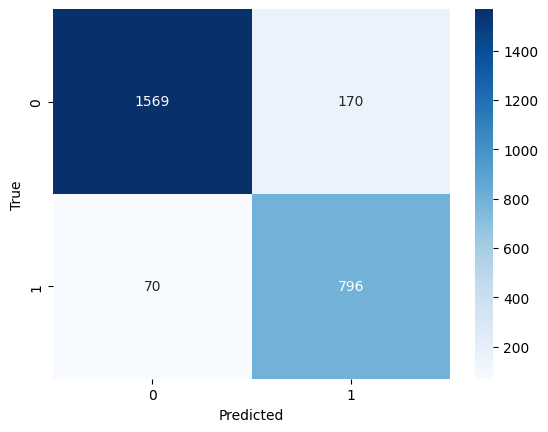

In [ ]:
threshold = 0.5
true_labels = []
predicted_labels = []
for images,labels in test_ds:
    probabilities = binary_classifier.predict(images, verbose=0)[:,0]
    predicted_labels += list((probabilities > threshold).astype(int))
    true_labels += list(labels.numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predicted_labels)
print(f'Precision: {precision:.4f}')

recall = recall_score(true_labels, predicted_labels)
print(f'Recall: {recall:.4f}')

f1 = f1_score(true_labels, predicted_labels)
print(f'F1 Score: {f1:.4f}')

conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
